In [20]:
import tensorflow as tf
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from tqdm import tqdm
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import os
import importlib

# dir_r3 = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/Data/out'
dir_ml = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/Data/out'
randseed = 42
print("random seed: ", randseed)
np.random.seed(randseed)

def choose_data(dat, test_size, val_size):
    if dat == 'ml2':
        train = pd.read_csv(os.path.join(dir_ml, 'ml_train2.csv'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")
        test = pd.read_csv(os.path.join(dir_ml, 'ml_test2.csv'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")
        val = None  # Assuming no validation set for 'ml2'
    elif dat == 'ml':
        ml_full = pd.read_csv(os.path.join(dir_ml, 'ml-1m_full.csv'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")

        # Get unique user IDs

        user_ids = ml_full['userId'].unique()
        item_ids = ml_full['songId'].unique()

        n_users = len(user_ids)
        n_items = len(item_ids)
        # Split user IDs for train, validation, and test sets
        train, test = train_test_split(ml_full, test_size=test_size, random_state=42)
        train, val = train_test_split(train, test_size=val_size/(1-test_size), random_state=42)

    else:
        print('Wrong data input')
        return None, None, None

    # Print the sizes of the datasets
    print(f"Train set size: {train.shape[0]} ratings")
    print(f"Validation set size: {val.shape[0] if val is not None else 0} ratings")
    print(f"Test set size: {test.shape[0]} ratings")
    print(ml_full.shape[0])
    print(train.shape[0] + val.shape[0] +  test.shape[0])

    return train, val, test, n_users, n_items

def load_confounders(dat, k):
    CAUSEFIT_DIR = f'C:/Users/Sten Stokroos/Desktop/NEW/zelf/Data/exposure_output/{dat}_exp_k_{k}.csv'
    conf_df = pd.read_csv(CAUSEFIT_DIR, header=None)
    confounder_data = conf_df.to_numpy().T
    return confounder_data

def load_data_rating(dat, columns=[0, 1, 2], sep="\t", include_validation=False, test_size=0.1, val_size=0.1):
    train, val, test, n_users, n_items = choose_data(dat, test_size, val_size)

    if train is None or test is None:
        return None, None, None, None, None

    if include_validation:
        # Use the provided validation set
        vad = val
    else:
        # Merge train and validation sets if validation is not required, and sort by userId
        train = pd.concat([train, val]).sort_values(by='userId').reset_index(drop=True)
        vad = None

    def build_matrix(df):
        rows = []
        cols = []
        ratings = []
        for line in df.itertuples():
            rows.append(line[1])
            cols.append(line[2])
            ratings.append(line[3])
        return csr_matrix((ratings, (rows, cols)), shape=(n_users, n_items)).todok()

    train_matrix = build_matrix(train)
    test_matrix = build_matrix(test)
    vad_matrix = build_matrix(vad) if vad is not None else None

    print("Load data finished. Number of users:", n_users, "Number of items:", n_items)
    return train_matrix, test_matrix, vad_matrix, n_users, n_items






random seed:  42


In [22]:
def run_model(module_name, class_name, k, dat='ml', include_validation=False, use_confounder=False, use_exposure=False, test_size=0.1, val_size=0.1, hidden_neuron=500, learning_rate=0.001, reg_rate=0.1, epoch=20, batch_size=200, verbose=False, T=1, display_step=1000, save_path=None):
    train, test, vad, user, item = load_data_rating(dat, columns=[0, 1, 2], sep="\t", include_validation=include_validation, test_size=test_size, val_size=val_size)

    confounder_data = None
    exposure_data = None

    if use_confounder:
        # Load confounder data
        confounder_data = load_confounders(dat, k)
    if use_exposure:
        # Create exposure matrix
        exposure_data = (train > 0).astype(np.float32).todense().T

    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True

    with tf.compat.v1.Session(config=config) as sess:
        module = importlib.import_module(module_name)
        model_class = getattr(module, class_name)
        final_model = model_class(sess, user, item, learning_rate=learning_rate, reg_rate=reg_rate, epoch=epoch, batch_size=batch_size, verbose=verbose, T=T, display_step=display_step)

        final_model.build_network(hidden_neuron=hidden_neuron)
        
        if confounder_data is not None and exposure_data is not None:
            final_model.execute(train, vad, confounder_data, exposure_data)
        elif confounder_data is not None:
            final_model.execute(train, vad, confounder_data)
        else:
            final_model.execute(train, vad)

        if vad is not None:
            if confounder_data is not None and exposure_data is not None:
                rmse, mae = final_model.test(vad, confounder_data, exposure_data)
            elif confounder_data is not None:
                rmse, mae = final_model.test(vad, confounder_data)
            else:
                rmse, mae = final_model.test(vad)
        else:
            rmse, mae = None, None

    return rmse, mae

def objective_urec1conf(params):
    learning_rate = params['learning_rate']
    reg_rate = params['reg_rate']
    hidden_neuron = params['hidden_neuron']
    k = params['k']

    rmse, mae = run_model('urec_1_conf', 'UAutoRec1conf', k, dat='ml', include_validation=True, use_confounder=True, use_exposure=False, hidden_neuron=hidden_neuron, learning_rate=learning_rate, reg_rate=reg_rate, batch_size=500, epoch=30)
    
    return {'loss': rmse, 'status': STATUS_OK}


def objective_urec2confexp(params):
    learning_rate = params['learning_rate']
    reg_rate = params['reg_rate']
    hidden_neuron = params['hidden_neuron']
    k = params['k']

    rmse, mae = run_model('urec_2_confexp', 'UAutoRec2confexp', k, dat='ml', include_validation=True, use_confounder=True, use_exposure=True, hidden_neuron=hidden_neuron, learning_rate=learning_rate, reg_rate=reg_rate, batch_size=500, epoch=30)
    
    return {'loss': rmse, 'status': STATUS_OK}


In [24]:
space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),
    'reg_rate': hp.loguniform('reg_rate', np.log(0.001), np.log(1000)),
    'hidden_neuron': hp.choice('hidden_neuron', [10, 20, 40, 80, 100, 200, 300, 400, 500]),
    'k': hp.choice('k', [1, 2, 5, 10, 20, 32, 50, 100]),
}

trials_urec2confexp = Trials()
best_urec2confexp = fmin(fn=objective_urec2confexp, space=space, algo=tpe.suggest, max_evals=20, trials=trials_urec2confexp)

print("Best parameters for UAutoRec1conf:", best_urec2confexp)

best_params_urec2confexp = {
    'learning_rate': best_urec2confexp['learning_rate'],
    'reg_rate': best_urec2confexp['reg_rate'],
    'hidden_neuron': [10, 20, 40, 80, 100, 200, 300, 400, 500][best_urec2confexp['hidden_neuron']],
    'k': [1, 2, 5, 10, 20, 32, 50, 100][best_urec2confexp['k']]
}

print("Best parameters for UAutoRec1conf in detailed form:", best_params_urec2confexp)



Train set size: 800169 ratings                        
Validation set size: 100022 ratings                   
Test set size: 100022 ratings                         
1000213                                               
1000213                                               
Load data finished. Number of users:                  
6040                                                  
Number of items:                                      
3706                                                  
UAutoRec with Confounder and Exposure.                
  0%|          | 0/20 [00:12<?, ?trial/s, best loss=?]

Training: 100%|##########| 30/30 [02:03<00:00,  4.13s/epoch, Loss=7.22e+4, RMSE=1, MAE=0.795]


Train set size: 800169 ratings                                                     
Validation set size: 100022 ratings                                                
Test set size: 100022 ratings                                                      
1000213                                                                            
1000213                                                                            
Load data finished. Number of users:                                               
6040                                                                               
Number of items:                                                                   
3706                                                                               
UAutoRec with Confounder and Exposure.                                             
  5%|▌         | 1/20 [04:17<1:17:40, 245.28s/trial, best loss: 1.0000431572660413]

Training: 100%|##########| 30/30 [02:06<00:00,  4.20s/epoch, Loss=5.36e+4, RMSE=0.901, MAE=0.716]


Train set size: 800169 ratings                                                     
Validation set size: 100022 ratings                                                
Test set size: 100022 ratings                                                      
1000213                                                                            
1000213                                                                            
Load data finished. Number of users:                                               
6040                                                                               
Number of items:                                                                   
3706                                                                               
UAutoRec with Confounder and Exposure.                                             
 10%|█         | 2/20 [08:31<1:15:08, 250.47s/trial, best loss: 0.9010547908826481]

Training: 100%|##########| 30/30 [02:53<00:00,  5.77s/epoch, Loss=5.44e+4, RMSE=0.932, MAE=0.737]


Train set size: 800169 ratings                                                     
Validation set size: 100022 ratings                                                
Test set size: 100022 ratings                                                      
1000213                                                                            
1000213                                                                            
Load data finished. Number of users:                                               
6040                                                                               
Number of items:                                                                   
3706                                                                               
UAutoRec with Confounder and Exposure.                                             
 15%|█▌        | 3/20 [13:30<1:17:15, 272.68s/trial, best loss: 0.9010547908826481]

Training: 100%|##########| 30/30 [02:54<00:00,  5.81s/epoch, Loss=4.95e+4, RMSE=0.906, MAE=0.716]


Train set size: 800169 ratings                                                     
Validation set size: 100022 ratings                                                
Test set size: 100022 ratings                                                      
1000213                                                                            
1000213                                                                            
Load data finished. Number of users:                                               
6040                                                                               
Number of items:                                                                   
3706                                                                               
UAutoRec with Confounder and Exposure.                                             
 20%|██        | 4/20 [18:24<1:14:55, 281.00s/trial, best loss: 0.9010547908826481]

Training: 100%|##########| 30/30 [02:06<00:00,  4.23s/epoch, Loss=8.51e+4, RMSE=1, MAE=0.801]


Train set size: 800169 ratings                                                     
Validation set size: 100022 ratings                                                
Test set size: 100022 ratings                                                      
1000213                                                                            
1000213                                                                            
Load data finished. Number of users:                                               
6040                                                                               
Number of items:                                                                   
3706                                                                               
UAutoRec with Confounder and Exposure.                                             
 25%|██▌       | 5/20 [22:29<1:07:02, 268.18s/trial, best loss: 0.9010547908826481]

Training: 100%|##########| 30/30 [02:43<00:00,  5.46s/epoch, Loss=6.43e+4, RMSE=0.984, MAE=0.787]


Train set size: 800169 ratings                                                     
Validation set size: 100022 ratings                                                
Test set size: 100022 ratings                                                      
1000213                                                                            
1000213                                                                            
Load data finished. Number of users:                                               
6040                                                                               
Number of items:                                                                   
3706                                                                               
UAutoRec with Confounder and Exposure.                                             
 30%|███       | 6/20 [27:20<1:04:22, 275.89s/trial, best loss: 0.9010547908826481]

Training: 100%|##########| 30/30 [02:06<00:00,  4.23s/epoch, Loss=6.41e+4, RMSE=0.98, MAE=0.784]


Train set size: 800169 ratings                                                     
Validation set size: 100022 ratings                                              
Test set size: 100022 ratings                                                    
1000213                                                                          
1000213                                                                          
Load data finished. Number of users:                                             
6040                                                                             
Number of items:                                                                 
3706                                                                             
UAutoRec with Confounder and Exposure.                                           
 35%|███▌      | 7/20 [31:33<58:03, 267.99s/trial, best loss: 0.9010547908826481]

Training: 100%|##########| 30/30 [03:04<00:00,  6.16s/epoch, Loss=6.95e+4, RMSE=0.978, MAE=0.78]


Train set size: 800169 ratings                                                   
Validation set size: 100022 ratings                                              
Test set size: 100022 ratings                                                    
1000213                                                                          
1000213                                                                          
Load data finished. Number of users:                                             
6040                                                                             
Number of items:                                                                 
3706                                                                             
UAutoRec with Confounder and Exposure.                                           
 40%|████      | 8/20 [36:43<56:15, 281.29s/trial, best loss: 0.9010547908826481]

Training:  70%|#######   | 21/30 [01:31<00:38,  4.28s/epoch, Loss=6.42e+4, RMSE=0.982, MAE=0.784]


Early stopping at epoch 20                                                       
 40%|████      | 8/20 [40:02<56:15, 281.29s/trial, best loss: 0.9010547908826481]

Training:  70%|#######   | 21/30 [01:31<00:39,  4.34s/epoch, Loss=6.42e+4, RMSE=0.982, MAE=0.784]


Train set size: 800169 ratings                                                   
Validation set size: 100022 ratings                                              
Test set size: 100022 ratings                                                    
1000213                                                                          
1000213                                                                          
Load data finished. Number of users:                                             
6040                                                                             
Number of items:                                                                 
3706                                                                             
UAutoRec with Confounder and Exposure.                                           
 45%|████▌     | 9/20 [40:17<47:45, 260.50s/trial, best loss: 0.9010547908826481]

Training: 100%|##########| 30/30 [02:00<00:00,  4.03s/epoch, Loss=1.21e+5, RMSE=1.06, MAE=0.854]


Train set size: 800169 ratings                                                    
Validation set size: 100022 ratings                                               
Test set size: 100022 ratings                                                     
1000213                                                                           
1000213                                                                           
Load data finished. Number of users:                                              
6040                                                                              
Number of items:                                                                  
3706                                                                              
UAutoRec with Confounder and Exposure.                                            
 50%|█████     | 10/20 [44:18<42:26, 254.67s/trial, best loss: 0.9010547908826481]

Training: 100%|##########| 30/30 [02:53<00:00,  5.78s/epoch, Loss=7.63e+4, RMSE=0.98, MAE=0.783]


Train set size: 800169 ratings                                                    
Validation set size: 100022 ratings                                               
Test set size: 100022 ratings                                                     
1000213                                                                           
1000213                                                                           
Load data finished. Number of users:                                              
6040                                                                              
Number of items:                                                                  
3706                                                                              
UAutoRec with Confounder and Exposure.                                            
 55%|█████▌    | 11/20 [49:13<40:02, 266.93s/trial, best loss: 0.9010547908826481]

Training:  83%|########3 | 25/30 [02:02<00:25,  5.03s/epoch, Loss=1.22e+5, RMSE=1.01, MAE=0.813]


Early stopping at epoch 24                                                        
 55%|█████▌    | 11/20 [53:01<40:02, 266.93s/trial, best loss: 0.9010547908826481]

Training:  83%|########3 | 25/30 [02:02<00:24,  4.90s/epoch, Loss=1.22e+5, RMSE=1.01, MAE=0.813]


Train set size: 800169 ratings                                                    
Validation set size: 100022 ratings                                               
Test set size: 100022 ratings                                                     
1000213                                                                           
1000213                                                                           
Load data finished. Number of users:                                              
6040                                                                              
Number of items:                                                                  
3706                                                                              
UAutoRec with Confounder and Exposure.                                            
 60%|██████    | 12/20 [53:16<34:36, 259.56s/trial, best loss: 0.9010547908826481]

Training: 100%|##########| 30/30 [02:52<00:00,  5.76s/epoch, Loss=8.72e+4, RMSE=1.01, MAE=0.808]


Train set size: 800169 ratings                                                    
Validation set size: 100022 ratings                                               
Test set size: 100022 ratings                                                     
1000213                                                                           
1000213                                                                           
Load data finished. Number of users:                                              
6040                                                                              
Number of items:                                                                  
3706                                                                              
UAutoRec with Confounder and Exposure.                                            
 65%|██████▌   | 13/20 [58:16<31:44, 272.10s/trial, best loss: 0.9010547908826481]

Training: 100%|##########| 30/30 [02:08<00:00,  4.28s/epoch, Loss=6.98e+4, RMSE=1.02, MAE=0.814]


Train set size: 800169 ratings                                                      
Validation set size: 100022 ratings                                                 
Test set size: 100022 ratings                                                       
1000213                                                                             
1000213                                                                             
Load data finished. Number of users:                                                
6040                                                                                
Number of items:                                                                    
3706                                                                                
UAutoRec with Confounder and Exposure.                                              
 70%|███████   | 14/20 [1:02:26<26:30, 265.03s/trial, best loss: 0.9010547908826481]

Training: 100%|##########| 30/30 [02:07<00:00,  4.24s/epoch, Loss=6.34e+4, RMSE=0.98, MAE=0.783]


Train set size: 800169 ratings                                                      
Validation set size: 100022 ratings                                                 
Test set size: 100022 ratings                                                       
1000213                                                                             
1000213                                                                             
Load data finished. Number of users:                                                
6040                                                                                
Number of items:                                                                    
3706                                                                                
UAutoRec with Confounder and Exposure.                                              
 75%|███████▌  | 15/20 [1:06:32<21:38, 259.74s/trial, best loss: 0.9010547908826481]

Training: 100%|##########| 30/30 [02:06<00:00,  4.21s/epoch, Loss=8.31e+4, RMSE=0.977, MAE=0.778]


Train set size: 800169 ratings                                                      
Validation set size: 100022 ratings                                                 
Test set size: 100022 ratings                                                       
1000213                                                                             
1000213                                                                             
Load data finished. Number of users:                                                
6040                                                                                
Number of items:                                                                    
3706                                                                                
UAutoRec with Confounder and Exposure.                                              
 80%|████████  | 16/20 [1:10:38<17:02, 255.63s/trial, best loss: 0.9010547908826481]

Training: 100%|##########| 30/30 [02:11<00:00,  4.37s/epoch, Loss=8.67e+4, RMSE=0.972, MAE=0.774]


Train set size: 800169 ratings                                                      
Validation set size: 100022 ratings                                                 
Test set size: 100022 ratings                                                       
1000213                                                                             
1000213                                                                             
Load data finished. Number of users:                                                
6040                                                                                
Number of items:                                                                    
3706                                                                                
UAutoRec with Confounder and Exposure.                                              
 85%|████████▌ | 17/20 [1:14:50<12:42, 254.14s/trial, best loss: 0.9010547908826481]

Training: 100%|##########| 30/30 [02:03<00:00,  4.12s/epoch, Loss=8.54e+4, RMSE=0.996, MAE=0.8]


Train set size: 800169 ratings                                                      
Validation set size: 100022 ratings                                                 
Test set size: 100022 ratings                                                       
1000213                                                                             
1000213                                                                             
Load data finished. Number of users:                                                
6040                                                                                
Number of items:                                                                    
3706                                                                                
UAutoRec with Confounder and Exposure.                                              
 90%|█████████ | 18/20 [1:18:53<08:22, 251.16s/trial, best loss: 0.9010547908826481]

Training: 100%|##########| 30/30 [02:52<00:00,  5.75s/epoch, Loss=5.11e+4, RMSE=0.911, MAE=0.721]


Train set size: 800169 ratings                                                      
Validation set size: 100022 ratings                                                 
Test set size: 100022 ratings                                                       
1000213                                                                             
1000213                                                                             
Load data finished. Number of users:                                                
6040                                                                                
Number of items:                                                                    
3706                                                                                
UAutoRec with Confounder and Exposure.                                              
 95%|█████████▌| 19/20 [1:23:48<04:23, 263.83s/trial, best loss: 0.9010547908826481]

Training: 100%|##########| 30/30 [02:10<00:00,  4.37s/epoch, Loss=2.21e+5, RMSE=1.31, MAE=1.08]


100%|██████████| 20/20 [1:27:47<00:00, 263.35s/trial, best loss: 0.9010547908826481]
Best parameters for UAutoRec1conf: {'hidden_neuron': 2, 'k': 2, 'learning_rate': 0.014417717174187524, 'reg_rate': 0.7595083512484477}
Best parameters for UAutoRec1conf in detailed form: {'learning_rate': 0.014417717174187524, 'reg_rate': 0.7595083512484477, 'hidden_neuron': 40, 'k': 5}


In [25]:
def run_model(module_name, class_name, k, dat='ml', include_validation=False, use_confounder=False, use_exposure=False, test_size=0.1, val_size=0.1, hidden_neuron=500, learning_rate=0.001, reg_rate=0.1, epoch=20, batch_size=200, verbose=False, T=1, display_step=1000, save_path=None):
    train, test, vad, user, item = load_data_rating(dat, columns=[0, 1, 2], sep="\t", include_validation=include_validation, test_size=test_size, val_size=val_size)

    confounder_data = None
    exposure_data = None

    if use_confounder:
        # Load confounder data
        confounder_data = load_confounders(dat, k)
    if use_exposure:
        # Create exposure matrix
        exposure_data = (train > 0).astype(np.float32).todense().T
    
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True

    with tf.compat.v1.Session(config=config) as sess:
        # Dynamically import the module and create an instance of the chosen class
        module = importlib.import_module(module_name)
        model_class = getattr(module, class_name)
        final_model = model_class(sess, user, item, learning_rate=learning_rate, reg_rate=reg_rate, epoch=epoch, batch_size=batch_size, verbose=verbose, T=T, display_step=display_step)

        final_model.build_network(hidden_neuron=hidden_neuron)
        
        # Determine how many arguments to pass to the execute function
        if confounder_data is not None and exposure_data is not None:
            final_model.execute(train, test, confounder_data, exposure_data)
        elif confounder_data is not None:
            final_model.execute(train, test, confounder_data)
        else:
            final_model.execute(train, test)

        # Save the training and test RMSE values
        if save_path:
            class_folder = os.path.join(save_path, class_name.lower())
            os.makedirs(class_folder, exist_ok=True)

            train_loss_file = os.path.join(class_folder, f'TUNED_train_loss_highepochs2_{dat}_k{k}.npy')
            test_rmse_file = os.path.join(class_folder, f'TUNED_test_rmsehighepochs2_{dat}_k{k}.npy')


            np.save(train_loss_file, np.array(final_model.train_loss_history))
            np.save(test_rmse_file, np.array(final_model.test_rmse_history))



# Best parameters for UAutoRec1conf in detailed form: {'learning_rate': 0.00654788977303255, 'reg_rate': 1, 'hidden_neuron': 100, 'k': 100}
# Best parameters for UAutoRec1conf in detailed form: {'learning_rate': 0.000934753482, 'reg_rate': 1, 'hidden_neuron': 100, 'k': 50}

    
# print("Best parameters for UAutoRec1conf in detailed form:", best_params_urec1conf)
result_path = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/results'
run_model('urec_1_conf', 'UAutoRec1conf', best_params_urec2confexp['k'], dat='ml', include_validation=False, use_confounder=True, use_exposure=False, 
          hidden_neuron= 500, #best_params_urec1conf['hidden_neuron'], 
          learning_rate=best_params_urec2confexp['learning_rate'], 
          reg_rate=best_params_urec2confexp['reg_rate'], 
          batch_size=500, epoch=80, save_path = result_path)



Train set size: 800169 ratings
Validation set size: 100022 ratings
Test set size: 100022 ratings
1000213
1000213
Load data finished. Number of users: 6040 Number of items: 3706
UAutoRec with Confounder.
Train data processed shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training: 100%|██████████| 80/80 [06:48<00:00,  5.11s/epoch, Loss=3.36e+4, RMSE=1.02, MAE=0.806] 


uautorec1conf (k=50) - Train loss history shape: (80,)
uautorec1conf (k=50) - Test RMSE history shape: (80,)


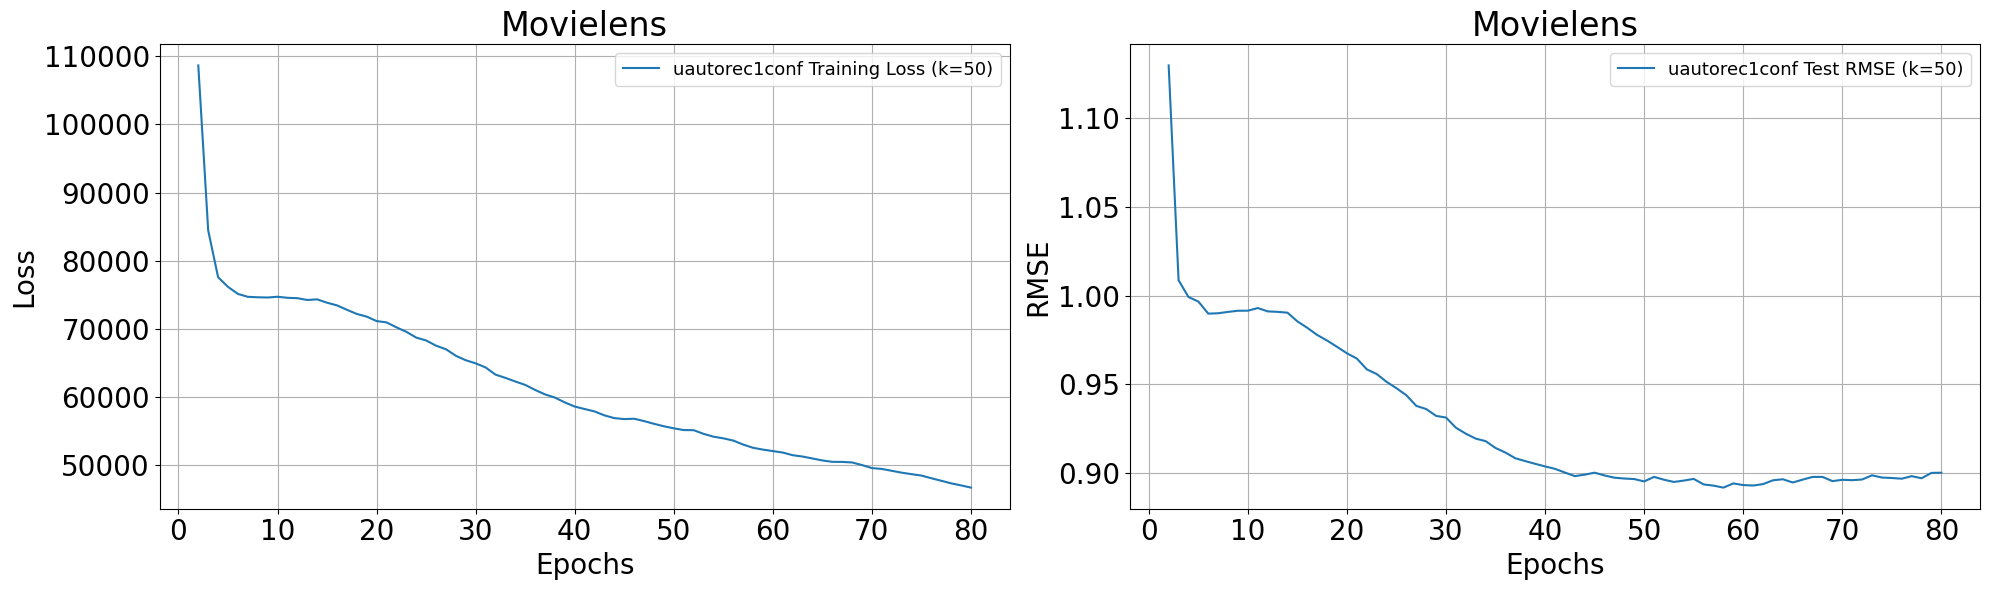

uautorec1conf (k=5) - Train loss history shape: (80,)
uautorec1conf (k=5) - Test RMSE history shape: (80,)
Plot saved to C:/Users/Sten Stokroos/Desktop/NEW/zelf/results\plots\TUNED_uautorec1conf_highepochs.png


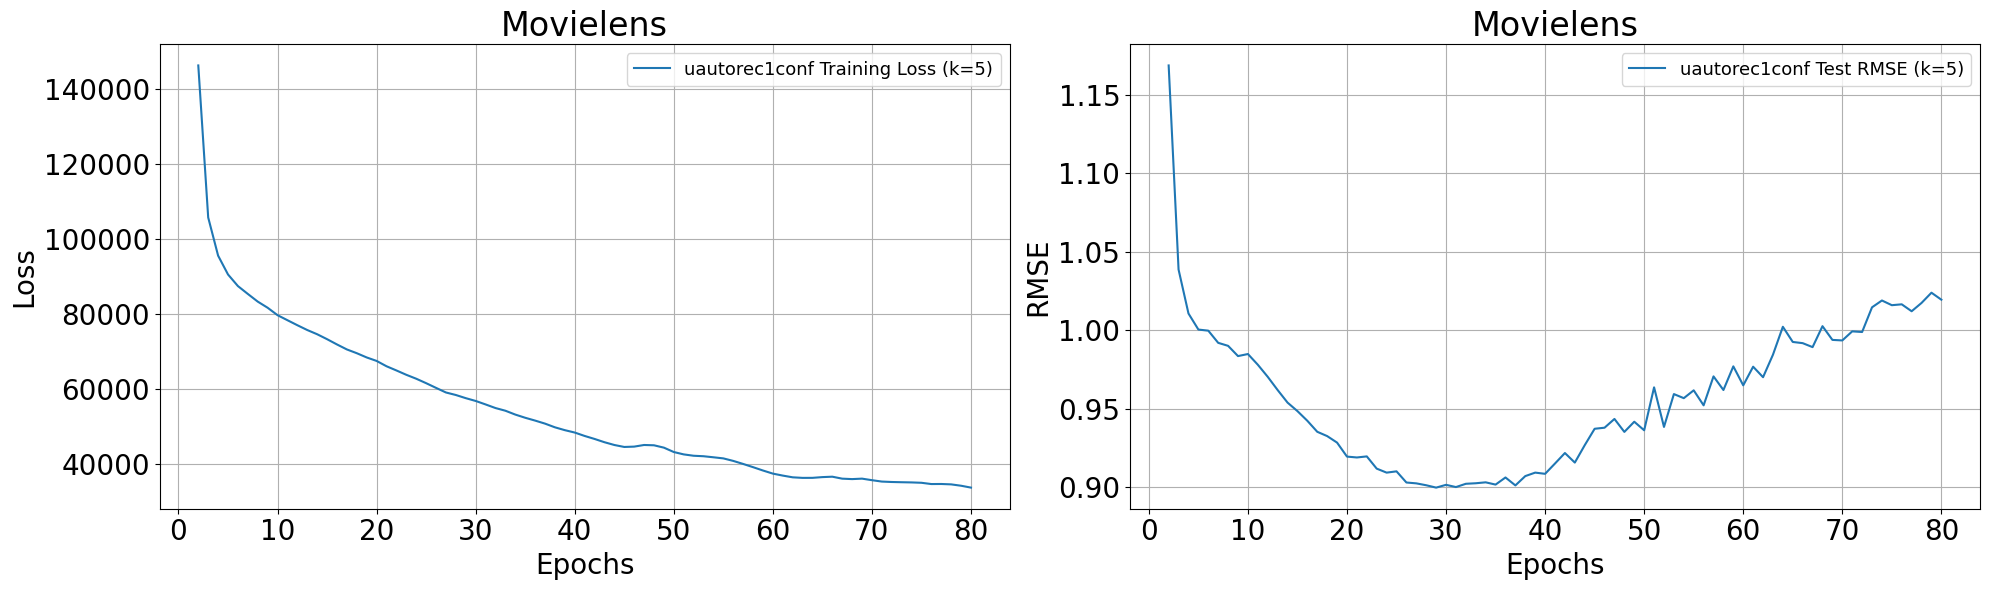

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_results(result_path, models, k_values, save_fig=False):
    plt.figure(figsize=(20, 6))

    for k in k_values:
        for model in models:
            class_name = model['class_name'].lower()
            class_folder = os.path.join(result_path, class_name)
            train_loss_file = os.path.join(class_folder, f'TUNED_train_loss_highepochs2_ml_k{k}.npy')
            test_rmse_file = os.path.join(class_folder, f'TUNED_test_rmsehighepochs2_ml_k{k}.npy')

            if not os.path.exists(train_loss_file) or not os.path.exists(test_rmse_file):
                print(f"Files for {class_name} with k={k} not found.")
                continue

            train_loss_history = np.load(train_loss_file)
            test_rmse_history = np.load(test_rmse_file)

            print(f"{class_name} (k={k}) - Train loss history shape: {train_loss_history.shape}")
            print(f"{class_name} (k={k}) - Test RMSE history shape: {test_rmse_history.shape}")

            epochs = np.arange(1, len(train_loss_history) + 1)

            # Plot training loss
            plt.subplot(1, 2, 1)
            plt.plot(epochs[1:], train_loss_history[1:], label=f'{class_name} Training Loss (k={k})')
            
            # Plot test RMSE
            plt.subplot(1, 2, 2)
            plt.plot(epochs[1:], test_rmse_history[1:], label=f'{class_name} Test RMSE (k={k})')

    plt.subplot(1, 2, 1)
    plt.xlabel('Epochs', fontsize=20)
    plt.ylabel('Loss', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.title('Movielens', fontsize=24)
    plt.legend(fontsize=13)
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.xlabel('Epochs', fontsize=20)
    plt.ylabel('RMSE', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.title('Movielens', fontsize=24)
    plt.legend(fontsize=13)
    plt.grid(True)

    plt.tight_layout()
    
    if save_fig:
        save_path = os.path.join(result_path, 'plots')
        os.makedirs(save_path, exist_ok=True)
        fig_file = os.path.join(save_path, f'TUNED_{class_name}_highepochs.png')
        plt.savefig(fig_file, dpi=300)
        print(f"Plot saved to {fig_file}")

    plt.show()

# Example usage
result_path = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/results'
models = [
    # {'module_name': 'urec_og', 'class_name': 'UAutoRec'},
    {'module_name': 'urec_1_conf', 'class_name': 'UAutoRec1Conf'},
    # {'module_name': 'urec_1_confexp', 'class_name': 'UAutoRec1ConfExp'},
    # {'module_name': 'urec_2_conf', 'class_name': 'UAutoRec2Conf'},
    # {'module_name': 'urec_2_confexp', 'class_name': 'UAutoRec2ConfExp'},
    # {'module_name': 'urec_3_conf', 'class_name': 'UAutoRec3Conf'},
    # {'module_name': 'urec_3_confexp', 'class_name': 'UAutoRec3ConfExp'},
    # {'module_name': 'urec_4_conf', 'class_name': 'UAutoRec4Conf'},
    # {'module_name': 'urec_4_confexp', 'class_name': 'UAutoRec4ConfExp'}
]
k_values = [5]  # Add all the k values you want to plot

plot_results(result_path, models, k_values, save_fig=True)
